In [24]:
import requests
from datetime import datetime
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
import xgboost as xgb
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from itertools import product
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
import statsmodels.api as sm


warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_alpha_vantage_data(symbol, api_key):
    base_url = 'https://www.alphavantage.co/query'
    function = 'TIME_SERIES_DAILY'
    
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': api_key,
        'outputsize': 'full'
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if 'Time Series (Daily)' not in data:
        print("Error: ", data.get('Error Message', 'Unknown error'))
        return None

    return data['Time Series (Daily)']




api_key = 'LDS6QLMELH5AYPSI'
symbol = 'SO'  

historical_data = get_alpha_vantage_data(symbol, api_key)

In [25]:
df_hist = pd.DataFrame(historical_data)
df_hist = df_hist.transpose()
df_hist

,1. open,2. high,3. low,4. close,5. volume
2025-01-10,82.3000,82.9250,81.2000,81.3200,5002352
2025-01-08,81.5200,83.0500,81.3100,83.0200,7807790
2025-01-07,81.1100,82.1000,80.9700,81.0900,4533262
2025-01-06,82.0300,82.3800,80.4600,80.9600,5375573
2025-01-03,82.2700,83.0000,82.1000,82.3200,4648524
...,...,...,...,...,...
1999-11-05,26.1300,26.5000,26.0600,26.1300,2500200
1999-11-04,26.1900,26.5600,25.8100,25.8800,1786700
1999-11-03,26.3800,26.4400,26.0600,26.1900,1817300
1999-11-02,26.4400,26.7500,26.3800,26.3800,1385900


In [26]:
volume = df_hist['5. volume'][::-1].astype(int)
close = df_hist['4. close'][::-1].astype(float)

<Axes: ylabel='5. volume'>

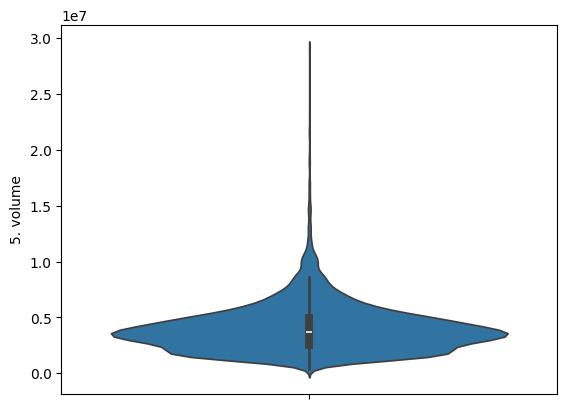

In [27]:
sns.violinplot(volume)

<Axes: ylabel='5. volume'>

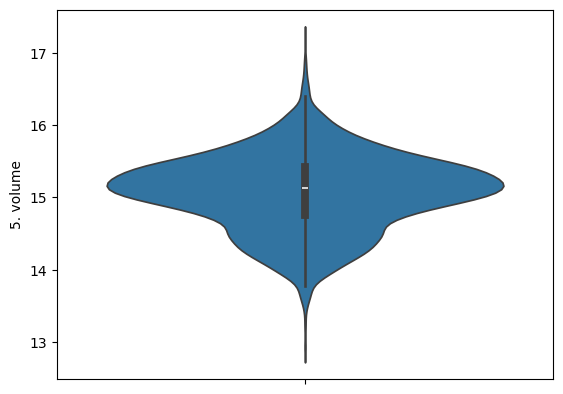

In [28]:
sns.violinplot(np.log(volume))

In [29]:
volume = np.log(volume)

In [30]:
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))

# ax1.plot(volume)
# ax1.set_title('Volume')

# ax2.plot(close)
# ax2.set_title('Closing_prices')

# plt.tight_layout()

In [31]:
print("The p-value for the adfuller test on the (differentiated) closing prices is: ", adfuller(close.diff().dropna())[1])

The p-value for the adfuller test on the (differentiated) closing prices is:  0.0


In [32]:
import itertools

p_values = [0, 1, 2, 3, 4, 5] 
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5] 

results_list = []

# 2. Grid-search across (p, d, q) combinations
for p, d, q in itertools.product(p_values, d_values, q_values):
    model = sm.tsa.ARIMA(list(close), order=(p, d, q))
    model_fit = model.fit()
    
    # Only add if convergence successful
    if model_fit.mle_retvals['converged']:
        aic = round(model_fit.aic, 2)
        bic = round(model_fit.bic, 2)
        results_list.append((p, d, q, aic, bic))

# 3. Convert to a DataFrame for easy comparison
results_df = pd.DataFrame(results_list, columns=['p', 'd', 'q', 'aic', 'bic'])

results_df

C:\Users\Darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Darius\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

,p,d,q,aic,bic
0,0,1,0,11857.22,11863.98
1,0,1,1,11843.85,11857.36
2,0,1,2,11845.62,11865.88
3,0,1,3,11845.83,11872.85
4,0,1,4,11818.72,11852.49
5,0,1,5,11818.09,11858.61
6,1,1,0,11843.69,11857.20
7,1,1,1,11845.56,11865.83
8,1,1,2,11847.56,11874.57
9,1,1,3,11822.36,11856.13


In [33]:
results_df.sort_values(by='aic').head()

,p,d,q,aic,bic
15,2,1,3,11778.98,11819.50
26,5,1,2,11784.07,11838.10
23,4,1,2,11788.59,11835.87
22,4,1,1,11790.56,11831.09
25,5,1,1,11792.03,11839.31


In [34]:
results_df.sort_values(by='bic').head()

,p,d,q,aic,bic
15,2,1,3,11778.98,11819.50
22,4,1,1,11790.56,11831.09
10,1,1,4,11794.72,11835.24
23,4,1,2,11788.59,11835.87
26,5,1,2,11784.07,11838.10


BEST PARAMETERS CHOSEN: p=2, q=1, q=3

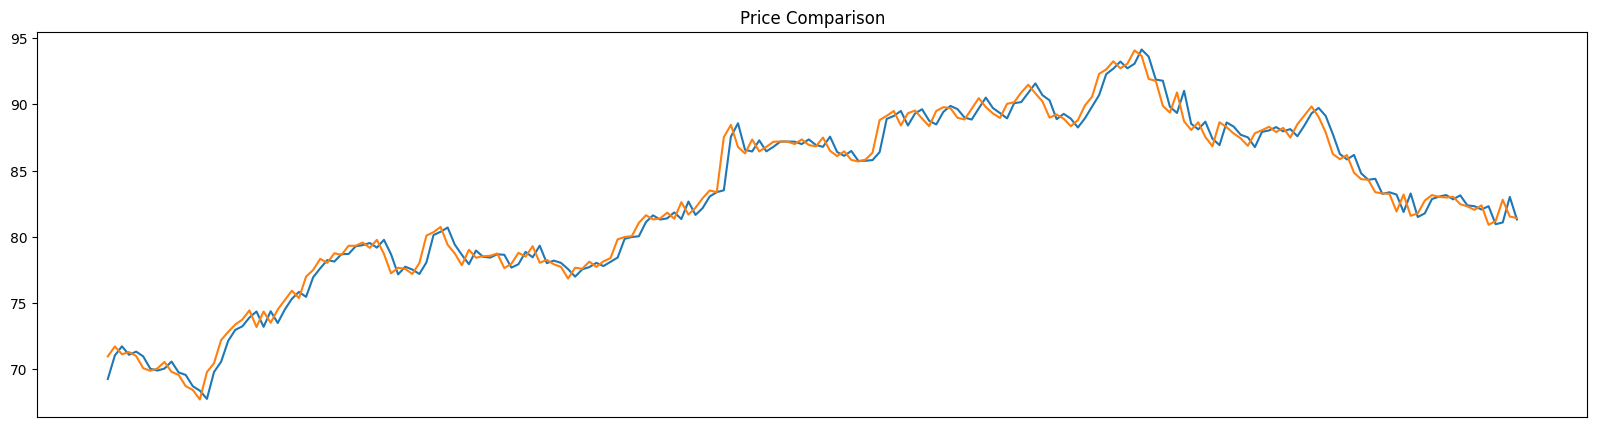

In [35]:
model = ARIMA(list(close), order=(2, 1, 3)) 
model_fit = model.fit()

predictions_close = model_fit.predict(start=2, end=len(close)+1)

plt.figure(figsize=(20,5))
plt.plot(close[-200:], label='Actual')
plt.plot(predictions_close[-200:], label='Predicted')
plt.xticks([])
plt.title('Price Comparison')
plt.show()

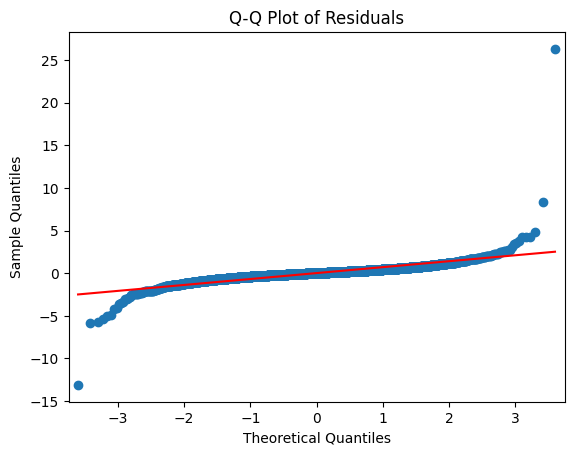

In [36]:
residuals = model_fit.resid

# Optional: Q-Q plot to check normality
import scipy.stats as stats
import statsmodels.api as sm

sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

CONSTRUTING DATETIME

In [37]:
date = pd.DataFrame({'Date' : df_hist.index})
date = date.astype('datetime64[ns]')

In [38]:
date['year'] = date['Date'].dt.year
date['month'] = date['Date'].dt.month
date['day'] = date['Date'].dt.day

In [39]:
df = pd.DataFrame({'closing_prices' : reversed(list(close)), 'next_day_forecast' : reversed(predictions_close), 'volume': reversed(list(volume)), 'year': list(date['year']), 'month': list(date['month']), 'day': list(date['day'])}, index=df_hist.index)
df

,closing_prices,next_day_forecast,volume,year,month,day
2025-01-10,81.32,81.425593,15.425419,2025,1,10
2025-01-08,83.02,81.538406,15.870633,2025,1,8
2025-01-07,81.09,82.806507,15.326952,2025,1,7
2025-01-06,80.96,81.195691,15.497376,2025,1,6
2025-01-03,82.32,80.913816,15.352060,2025,1,3
...,...,...,...,...,...,...
1999-11-05,26.13,25.956507,14.731881,1999,11,5
1999-11-04,25.88,26.109385,14.395881,1999,11,4
1999-11-03,26.19,25.894428,14.412862,1999,11,3
1999-11-02,26.38,26.200038,14.141860,1999,11,2


In [40]:

mean_values = [2,4,7,11,16,22,30]
volume_values = [2,4,7]


def calc_means(df, values, mean_values):
    for num in mean_values:
        rolling_mean = values.rolling(window=num).mean()[::-1]
        rolling_mean.index = df.index 
        df[f'mean_{num}'] = rolling_mean
    return df

def calc_volumes(df, values, volume_values):
    for num in volume_values:
        rolling_mean = values.rolling(window=num).mean()[::-1]
        rolling_mean.index = df.index 
        df[f'vol_{num}'] = rolling_mean
    return df

df = calc_means(df, close, mean_values)
df = calc_volumes(df, volume, volume_values)
df.dropna(inplace=True)
df

,closing_prices,next_day_forecast,volume,year,month,day,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7
2025-01-10,81.32,81.425593,15.425419,2025,1,10,82.170,81.5975,81.871429,82.238182,82.317500,82.612727,83.885333,15.648026,15.530095,15.310556
2025-01-08,83.02,81.538406,15.870633,2025,1,8,82.055,81.8475,82.022857,82.394545,82.352500,82.771364,84.122000,15.598792,15.511755,15.271777
2025-01-07,81.09,82.806507,15.326952,2025,1,7,81.025,81.6100,82.040000,82.380000,82.363750,82.915455,84.274667,15.412164,15.242000,15.114877
2025-01-06,80.96,81.195691,15.497376,2025,1,6,81.640,81.9175,82.290000,82.442727,82.506250,83.131818,84.509667,15.424718,15.137722,15.010124
2025-01-03,82.32,80.913816,15.352060,2025,1,3,82.195,82.2725,82.604286,82.491818,82.649375,83.372727,84.743333,15.071835,15.051870,14.789368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-17,23.56,23.266395,15.272683,1999,12,17,23.345,23.2050,22.842857,23.070909,23.170000,23.410909,23.937000,14.985070,15.022895,14.983956
1999-12-16,23.13,23.493841,14.697458,1999,12,16,23.285,22.9125,22.762857,23.088182,23.170000,23.473636,24.014333,14.846596,14.908613,14.905609
1999-12-15,23.44,23.208666,14.995734,1999,12,15,23.065,22.7875,22.780000,23.116364,23.189375,23.561364,24.116333,15.060720,14.926696,14.875919
1999-12-14,22.69,23.353800,15.125707,1999,12,14,22.540,22.4425,22.815714,23.110909,23.224375,23.640909,24.214333,14.970630,14.980454,14.780079


In [41]:
previous_row_val = -1
df['Target'] = np.zeros(len(df))

for index, row in df.iterrows():
    if previous_row_val != -1:
        if previous_row_val > row['closing_prices']:
            df.loc[index, 'Target'] = 1

    previous_row_val = row['closing_prices']

df
    

,closing_prices,next_day_forecast,volume,year,month,day,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,Target
2025-01-10,81.32,81.425593,15.425419,2025,1,10,82.170,81.5975,81.871429,82.238182,82.317500,82.612727,83.885333,15.648026,15.530095,15.310556,0.0
2025-01-08,83.02,81.538406,15.870633,2025,1,8,82.055,81.8475,82.022857,82.394545,82.352500,82.771364,84.122000,15.598792,15.511755,15.271777,0.0
2025-01-07,81.09,82.806507,15.326952,2025,1,7,81.025,81.6100,82.040000,82.380000,82.363750,82.915455,84.274667,15.412164,15.242000,15.114877,1.0
2025-01-06,80.96,81.195691,15.497376,2025,1,6,81.640,81.9175,82.290000,82.442727,82.506250,83.131818,84.509667,15.424718,15.137722,15.010124,1.0
2025-01-03,82.32,80.913816,15.352060,2025,1,3,82.195,82.2725,82.604286,82.491818,82.649375,83.372727,84.743333,15.071835,15.051870,14.789368,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-17,23.56,23.266395,15.272683,1999,12,17,23.345,23.2050,22.842857,23.070909,23.170000,23.410909,23.937000,14.985070,15.022895,14.983956,0.0
1999-12-16,23.13,23.493841,14.697458,1999,12,16,23.285,22.9125,22.762857,23.088182,23.170000,23.473636,24.014333,14.846596,14.908613,14.905609,1.0
1999-12-15,23.44,23.208666,14.995734,1999,12,15,23.065,22.7875,22.780000,23.116364,23.189375,23.561364,24.116333,15.060720,14.926696,14.875919,0.0
1999-12-14,22.69,23.353800,15.125707,1999,12,14,22.540,22.4425,22.815714,23.110909,23.224375,23.640909,24.214333,14.970630,14.980454,14.780079,1.0


In [42]:
correct = 0
wrong = 0

for index, row in df.iterrows():
    if row['closing_prices']/row['next_day_forecast'] < 1:
        if row['Target'] == 1:
            correct+=1
        else:
            wrong+=1
    else:
        if row['Target'] == 0:
            correct+=1
        else:
            wrong+=1
            
starting_accuracy = correct/(correct + wrong)
print(f'Starting accuracy (based solely on the ARIMA forecast): ', starting_accuracy)

Starting accuracy (based solely on the ARIMA forecast):  0.9586305278174037


C:\Users\Darius\AppData\Local\Temp\ipykernel_20500\3997516221.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24675739769029362' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'day_sin'] = np.sin(2 * np.pi * day_of_year / 252) #252 bussiness days in a year
C:\Users\Darius\AppData\Local\Temp\ipykernel_20500\3997516221.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.969077286229078' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'day_cos'] = np.cos(2 * np.pi * day_of_year / 252)


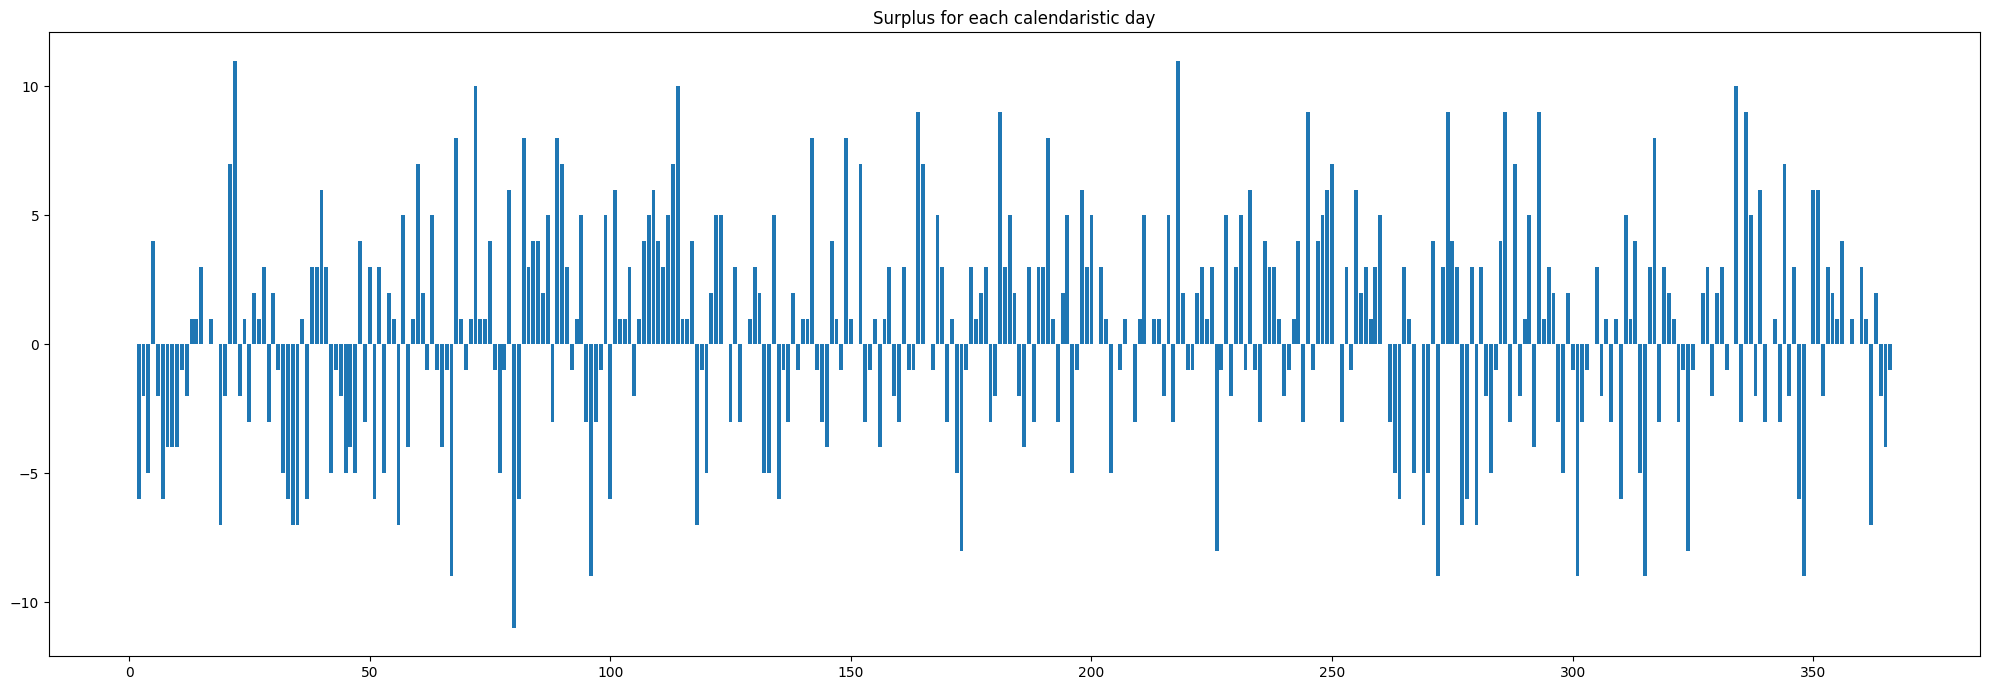

In [43]:


month_day_freq: Dict[int, int] = {}
df['day_sin'] = 0
df['day_cos'] = 0

for index, row in df.iterrows():
    date_value = datetime(int(row.year), int(row.month), int(row.day))

    day_of_year = date_value.timetuple().tm_yday

    df.loc[index, 'day_sin'] = np.sin(2 * np.pi * day_of_year / 252) #252 bussiness days in a year
    df.loc[index, 'day_cos'] = np.cos(2 * np.pi * day_of_year / 252)

    if day_of_year not in month_day_freq:
        month_day_freq[day_of_year] = 0
    
    if row.Target == 1:
        month_day_freq[day_of_year] += 1
    else:
        month_day_freq[day_of_year] -= 1

# Set figure size before plotting
plt.figure(figsize=(20, 7))
plt.bar(month_day_freq.keys(), month_day_freq.values())
plt.title("Surplus for each calendaristic day")
plt.tight_layout()



In [44]:
df.drop(columns=['year','month','day'], inplace=True)

In [45]:
df

,closing_prices,next_day_forecast,volume,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,Target,day_sin,day_cos
2025-01-10,81.32,81.425593,15.425419,82.170,81.5975,81.871429,82.238182,82.317500,82.612727,83.885333,15.648026,15.530095,15.310556,0.0,0.246757,0.969077
2025-01-08,83.02,81.538406,15.870633,82.055,81.8475,82.022857,82.394545,82.352500,82.771364,84.122000,15.598792,15.511755,15.271777,0.0,0.198146,0.980172
2025-01-07,81.09,82.806507,15.326952,81.025,81.6100,82.040000,82.380000,82.363750,82.915455,84.274667,15.412164,15.242000,15.114877,1.0,0.173648,0.984808
2025-01-06,80.96,81.195691,15.497376,81.640,81.9175,82.290000,82.442727,82.506250,83.131818,84.509667,15.424718,15.137722,15.010124,1.0,0.149042,0.988831
2025-01-03,82.32,80.913816,15.352060,82.195,82.2725,82.604286,82.491818,82.649375,83.372727,84.743333,15.071835,15.051870,14.789368,0.0,0.074730,0.997204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-17,23.56,23.266395,15.272683,23.345,23.2050,22.842857,23.070909,23.170000,23.410909,23.937000,14.985070,15.022895,14.983956,0.0,0.623490,-0.781831
1999-12-16,23.13,23.493841,14.697458,23.285,22.9125,22.762857,23.088182,23.170000,23.473636,24.014333,14.846596,14.908613,14.905609,1.0,0.642788,-0.766044
1999-12-15,23.44,23.208666,14.995734,23.065,22.7875,22.780000,23.116364,23.189375,23.561364,24.116333,15.060720,14.926696,14.875919,0.0,0.661686,-0.749781
1999-12-14,22.69,23.353800,15.125707,22.540,22.4425,22.815714,23.110909,23.224375,23.640909,24.214333,14.970630,14.980454,14.780079,1.0,0.680173,-0.733052


Text(0.5, 1.0, 'Percentage of days closing off higher or lower than in the previos day')

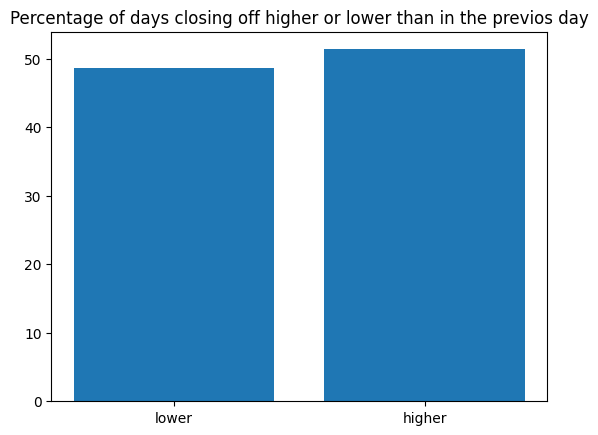

In [46]:
df3 = df.groupby(by=['Target']).count()

plt.bar(df3.index, df3['closing_prices']/63.09)
plt.xticks(ticks=[0, 1], labels=['lower', 'higher'])
plt.title('Percentage of days closing off higher or lower than in the previos day')

In [47]:
df['Target'] = df['Target'].astype('category')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6309 entries, 2025-01-10 to 1999-12-13
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   closing_prices     6309 non-null   float64 
 1   next_day_forecast  6309 non-null   float64 
 2   volume             6309 non-null   float64 
 3   mean_2             6309 non-null   float64 
 4   mean_4             6309 non-null   float64 
 5   mean_7             6309 non-null   float64 
 6   mean_11            6309 non-null   float64 
 7   mean_16            6309 non-null   float64 
 8   mean_22            6309 non-null   float64 
 9   mean_30            6309 non-null   float64 
 10  vol_2              6309 non-null   float64 
 11  vol_4              6309 non-null   float64 
 12  vol_7              6309 non-null   float64 
 13  Target             6309 non-null   category
 14  day_sin            6309 non-null   float64 
 15  day_cos            6309 non-null   float64 
d

In [49]:
y = df['Target']
df.drop(columns='Target', inplace=True)

In [50]:
col_to_div = ['closing_prices', 'next_day_forecast', 'mean_2', 'mean_4', 'mean_7', 'mean_11', 'mean_16', 'mean_22', 'mean_30']

df[col_to_div] = df[col_to_div].div(df['closing_prices'], axis=0)
df.drop(columns='closing_prices', inplace=True)

In [51]:
df['mean_4/7'] = df.loc[:,'mean_4'] / df.loc[:,'mean_7']
df['mean_4/11'] = df.loc[:,'mean_4'] / df.loc[:,'mean_11']
df['mean_4/16'] = df.loc[:,'mean_4'] / df.loc[:,'mean_16']
df['mean_11/16'] = df.loc[:,'mean_11'] / df.loc[:,'mean_16']
df

,next_day_forecast,volume,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,day_sin,day_cos,mean_4/7,mean_4/11,mean_4/16,mean_11/16
2025-01-10,1.001298,15.425419,1.010453,1.003412,1.006781,1.011291,1.012266,1.015897,1.031546,15.648026,15.530095,15.310556,0.246757,0.969077,0.996654,0.992209,0.991253,0.999036
2025-01-08,0.982154,15.870633,0.988376,0.985877,0.987989,0.992466,0.991960,0.997005,1.013274,15.598792,15.511755,15.271777,0.198146,0.980172,0.997862,0.993361,0.993868,1.000511
2025-01-07,1.021168,15.326952,0.999198,1.006413,1.011715,1.015908,1.015708,1.022511,1.039273,15.412164,15.242000,15.114877,0.173648,0.984808,0.994759,0.990653,0.990849,1.000197
2025-01-06,1.002911,15.497376,1.008399,1.011827,1.016428,1.018314,1.019099,1.026826,1.043845,15.424718,15.137722,15.010124,0.149042,0.988831,0.995473,0.993629,0.992864,0.999230
2025-01-03,0.982918,15.352060,0.998482,0.999423,1.003453,1.002087,1.004001,1.012788,1.029438,15.071835,15.051870,14.789368,0.074730,0.997204,0.995983,0.997341,0.995440,0.998094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-17,0.987538,15.272683,0.990874,0.984932,0.969561,0.979241,0.983447,0.993672,1.016002,14.985070,15.022895,14.983956,0.623490,-0.781831,1.015854,1.005812,1.001511,0.995723
1999-12-16,1.015730,14.697458,1.006701,0.990597,0.984127,0.998192,1.001729,1.014857,1.038233,14.846596,14.908613,14.905609,0.642788,-0.766044,1.006574,0.992391,0.988886,0.996469
1999-12-15,0.990131,14.995734,0.984002,0.972163,0.971843,0.986193,0.989308,1.005178,1.028854,15.060720,14.926696,14.875919,0.661686,-0.749781,1.000329,0.985774,0.982670,0.996852
1999-12-14,1.029255,15.125707,0.993389,0.989092,1.005541,1.018550,1.023551,1.041909,1.067181,14.970630,14.980454,14.780079,0.680173,-0.733052,0.983642,0.971078,0.966334,0.995114


In [52]:
col_to_div = ['vol_2', 'vol_4', 'vol_7']
df[col_to_div] = df[col_to_div].div(df['volume'], axis=0)

In [53]:
row_to_predict = df.iloc[0, :]
df.drop(df.index[0], inplace=True)
df

,next_day_forecast,volume,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,day_sin,day_cos,mean_4/7,mean_4/11,mean_4/16,mean_11/16
2025-01-08,0.982154,15.870633,0.988376,0.985877,0.987989,0.992466,0.991960,0.997005,1.013274,0.982872,0.977387,0.962266,0.198146,0.980172,0.997862,0.993361,0.993868,1.000511
2025-01-07,1.021168,15.326952,0.999198,1.006413,1.011715,1.015908,1.015708,1.022511,1.039273,1.005560,0.994457,0.986163,0.173648,0.984808,0.994759,0.990653,0.990849,1.000197
2025-01-06,1.002911,15.497376,1.008399,1.011827,1.016428,1.018314,1.019099,1.026826,1.043845,0.995312,0.976793,0.968559,0.149042,0.988831,0.995473,0.993629,0.992864,0.999230
2025-01-03,0.982918,15.352060,0.998482,0.999423,1.003453,1.002087,1.004001,1.012788,1.029438,0.981747,0.980446,0.963347,0.074730,0.997204,0.995983,0.997341,0.995440,0.998094
2025-01-02,1.003814,14.791611,1.001523,1.004965,1.007763,1.006203,1.008636,1.018892,1.034999,1.003997,1.007797,0.994073,0.049846,0.998757,0.997223,0.998770,0.996361,0.997588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-17,0.987538,15.272683,0.990874,0.984932,0.969561,0.979241,0.983447,0.993672,1.016002,0.981168,0.983645,0.981095,0.623490,-0.781831,1.015854,1.005812,1.001511,0.995723
1999-12-16,1.015730,14.697458,1.006701,0.990597,0.984127,0.998192,1.001729,1.014857,1.038233,1.010147,1.014367,1.014162,0.642788,-0.766044,1.006574,0.992391,0.988886,0.996469
1999-12-15,0.990131,14.995734,0.984002,0.972163,0.971843,0.986193,0.989308,1.005178,1.028854,1.004334,0.995396,0.992010,0.661686,-0.749781,1.000329,0.985774,0.982670,0.996852
1999-12-14,1.029255,15.125707,0.993389,0.989092,1.005541,1.018550,1.023551,1.041909,1.067181,0.989748,0.990397,0.977150,0.680173,-0.733052,0.983642,0.971078,0.966334,0.995114


In [54]:
X = df
y=y[1:]

<Axes: >

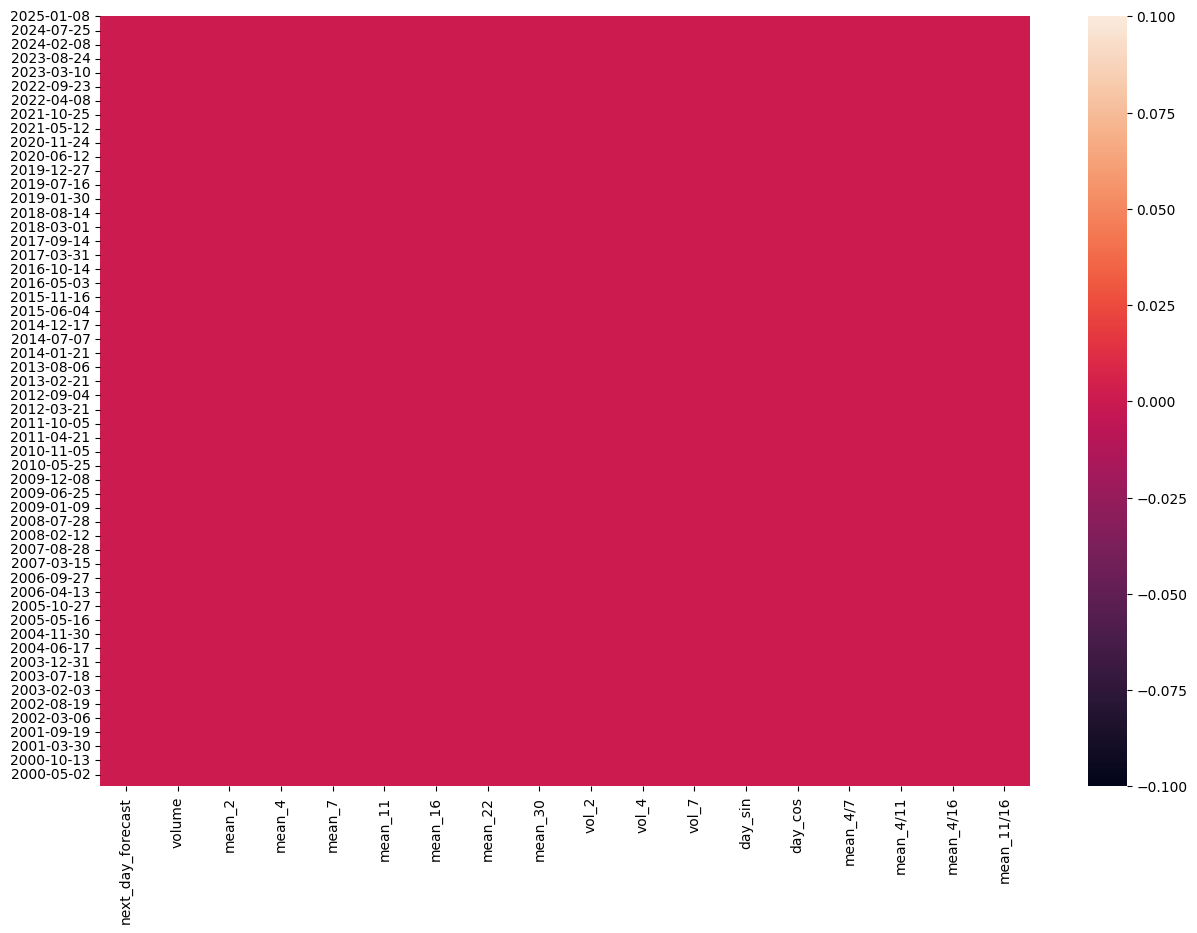

In [55]:
plt.figure(figsize=(15,10))
sns.heatmap(X.isna())

In [56]:
X

,next_day_forecast,volume,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,day_sin,day_cos,mean_4/7,mean_4/11,mean_4/16,mean_11/16
2025-01-08,0.982154,15.870633,0.988376,0.985877,0.987989,0.992466,0.991960,0.997005,1.013274,0.982872,0.977387,0.962266,0.198146,0.980172,0.997862,0.993361,0.993868,1.000511
2025-01-07,1.021168,15.326952,0.999198,1.006413,1.011715,1.015908,1.015708,1.022511,1.039273,1.005560,0.994457,0.986163,0.173648,0.984808,0.994759,0.990653,0.990849,1.000197
2025-01-06,1.002911,15.497376,1.008399,1.011827,1.016428,1.018314,1.019099,1.026826,1.043845,0.995312,0.976793,0.968559,0.149042,0.988831,0.995473,0.993629,0.992864,0.999230
2025-01-03,0.982918,15.352060,0.998482,0.999423,1.003453,1.002087,1.004001,1.012788,1.029438,0.981747,0.980446,0.963347,0.074730,0.997204,0.995983,0.997341,0.995440,0.998094
2025-01-02,1.003814,14.791611,1.001523,1.004965,1.007763,1.006203,1.008636,1.018892,1.034999,1.003997,1.007797,0.994073,0.049846,0.998757,0.997223,0.998770,0.996361,0.997588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-17,0.987538,15.272683,0.990874,0.984932,0.969561,0.979241,0.983447,0.993672,1.016002,0.981168,0.983645,0.981095,0.623490,-0.781831,1.015854,1.005812,1.001511,0.995723
1999-12-16,1.015730,14.697458,1.006701,0.990597,0.984127,0.998192,1.001729,1.014857,1.038233,1.010147,1.014367,1.014162,0.642788,-0.766044,1.006574,0.992391,0.988886,0.996469
1999-12-15,0.990131,14.995734,0.984002,0.972163,0.971843,0.986193,0.989308,1.005178,1.028854,1.004334,0.995396,0.992010,0.661686,-0.749781,1.000329,0.985774,0.982670,0.996852
1999-12-14,1.029255,15.125707,0.993389,0.989092,1.005541,1.018550,1.023551,1.041909,1.067181,0.989748,0.990397,0.977150,0.680173,-0.733052,0.983642,0.971078,0.966334,0.995114


In [57]:
def grid_search_xgboost(X, y, param_grid):
    X = X.values
    y = y.values 

    param_combinations = (dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values()))

    max_accuracy = 0
    best_params = None
    best_num_boost_round = 0

    n_splits = 10
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    num_boost_round = 1500
    early_stopping_rounds = 20

    for params in param_combinations:
        try:
            fold_accuracies = []
            fold_boost_rounds = []

            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test, label=y_test)

                evals_result = {}

                model = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dtrain, 'train'), (dtest, 'test')],
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=False,
                    evals_result=evals_result
                )

                optimal_rounds = model.best_iteration
                fold_boost_rounds.append(optimal_rounds)

                y_pred_prob = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
                y_pred = (y_pred_prob > 0.5).astype(int)  
                accuracy = accuracy_score(y_test, y_pred)
                fold_accuracies.append(accuracy)

            mean_accuracy = np.mean(fold_accuracies)
            mean_boost_rounds = np.mean(fold_boost_rounds)

            if mean_accuracy > max_accuracy:
                max_accuracy = mean_accuracy
                best_params = params.copy()
                best_num_boost_round = int(mean_boost_rounds)

        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
            continue

    
    print(f"Best cross-validated accuracy achieved: {max_accuracy:.4f}")
    print(f"Optimal number of boosting rounds (trees): {best_num_boost_round}")
    print("Best parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")


AFTER SUCCESSIVE PARAMETER SEARCHES, THE BEST ACCURACY FOUND WAS 0.9602

In [58]:

# param_grid = {
#     'max_depth': [7, 8],
#     'learning_rate': [0.075, 0.08, 0.085],
#     'subsample': [0.65, 0.7],
#     'colsample_bytree': [0.8, 0.85], 
#     'gamma': [6.5],
#     'min_child_weight': [1],
#     'objective': ['binary:logistic'],
#     'tree_method': ['hist'],
#     'device': ['cuda']
# }

# row_to_predict = row_to_predict.to_frame().T

# cX = X.copy()
# cr = row_to_predict.copy()

# for j in range(2,8):
#     col = X.columns[j]
#     for i in range(j+1,9):
#         X = cX.copy()
#         row_to_predict = cr.copy()
#         X[f'{col}/{X.columns[i]}'] = X.iloc[:,j] / X.iloc[:,i]
#         row_to_predict[f'{col}/{X.columns[i]}'] = row_to_predict.iloc[:,j] / row_to_predict.iloc[:,i]
#         print(f'Prediction for {col}/{X.columns[i]}')
#         grid_search_xgboost(X, y, param_grid)



In [59]:
# param_grid = {
#     'max_depth': [6, 7, 8],
#     'learning_rate': [0.08, 0.085],
#     'subsample': [0.65, 0.7],
#     'colsample_bytree': [0.8, 0.85], 
#     'gamma': [6.5],
#     'min_child_weight': [1],
#     'objective': ['binary:logistic'],
#     'tree_method': ['hist'],
#     'device': ['cuda']
# }

# cX = X.copy()
# cr = row_to_predict.copy()

# for j in range(9,11):
#     col = X.columns[j]
#     for i in range(j+1,12):
#         X = cX.copy()
#         row_to_predict = cr.copy()
#         X[f'{col}/{X.columns[i]}'] = X.iloc[:,j] / X.iloc[:,i]
#         row_to_predict[f'{col}/{X.columns[i]}'] = row_to_predict.iloc[:,j] / row_to_predict.iloc[:,i]
#         print(f'Prediction for {col}/{X.columns[i]}')
#         grid_search_xgboost(X, y, param_grid)

THE FOLLOWING FEATURE COMBINATIONS HAVE BEEN OBSERVED TO IMPROVE THE ACCURACY OF THE MODEL

In [60]:
# param_grid = {
#     'max_depth': [7, 9, 12],
#     'learning_rate': [0.07, 0.085, 0.1],
#     'subsample': [0.6, 0.8, 1],
#     'colsample_bytree': [0.6, 0.8, 1], 
#     'gamma': [0, 3, 6],
#     'min_child_weight': [0, 3, 6],
#     'objective': ['binary:logistic'],
#     'tree_method': ['hist'],
#     'device': ['cuda']
# }

# grid_search_xgboost(X, y, param_grid)

In [61]:
# param_grid = {
#     'max_depth': [8, 9, 11],
#     'learning_rate': [0.06, 0.07, 0.08],
#     'subsample': [0.5, 0.6, 0.7],
#     'colsample_bytree': [0.5, 0.6, 0.7], 
#     'gamma': [5, 6, 7],
#     'min_child_weight': [0, 0.5, 1],
#     'objective': ['binary:logistic'],
#     'tree_method': ['hist'],
#     'device': ['cuda']
# }

# grid_search_xgboost(X, y, param_grid)

In [62]:
X['mean_4/7'] = X.loc[:,'mean_4'] / X.loc[:,'mean_7']
X['mean_4/11'] = X.loc[:,'mean_4'] / X.loc[:,'mean_11']
X['mean_4/16'] = X.loc[:,'mean_4'] / X.loc[:,'mean_16']
X['mean_11/16'] = X.loc[:,'mean_11'] / X.loc[:,'mean_16']
X

,next_day_forecast,volume,mean_2,mean_4,mean_7,mean_11,mean_16,mean_22,mean_30,vol_2,vol_4,vol_7,day_sin,day_cos,mean_4/7,mean_4/11,mean_4/16,mean_11/16
2025-01-08,0.982154,15.870633,0.988376,0.985877,0.987989,0.992466,0.991960,0.997005,1.013274,0.982872,0.977387,0.962266,0.198146,0.980172,0.997862,0.993361,0.993868,1.000511
2025-01-07,1.021168,15.326952,0.999198,1.006413,1.011715,1.015908,1.015708,1.022511,1.039273,1.005560,0.994457,0.986163,0.173648,0.984808,0.994759,0.990653,0.990849,1.000197
2025-01-06,1.002911,15.497376,1.008399,1.011827,1.016428,1.018314,1.019099,1.026826,1.043845,0.995312,0.976793,0.968559,0.149042,0.988831,0.995473,0.993629,0.992864,0.999230
2025-01-03,0.982918,15.352060,0.998482,0.999423,1.003453,1.002087,1.004001,1.012788,1.029438,0.981747,0.980446,0.963347,0.074730,0.997204,0.995983,0.997341,0.995440,0.998094
2025-01-02,1.003814,14.791611,1.001523,1.004965,1.007763,1.006203,1.008636,1.018892,1.034999,1.003997,1.007797,0.994073,0.049846,0.998757,0.997223,0.998770,0.996361,0.997588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-17,0.987538,15.272683,0.990874,0.984932,0.969561,0.979241,0.983447,0.993672,1.016002,0.981168,0.983645,0.981095,0.623490,-0.781831,1.015854,1.005812,1.001511,0.995723
1999-12-16,1.015730,14.697458,1.006701,0.990597,0.984127,0.998192,1.001729,1.014857,1.038233,1.010147,1.014367,1.014162,0.642788,-0.766044,1.006574,0.992391,0.988886,0.996469
1999-12-15,0.990131,14.995734,0.984002,0.972163,0.971843,0.986193,0.989308,1.005178,1.028854,1.004334,0.995396,0.992010,0.661686,-0.749781,1.000329,0.985774,0.982670,0.996852
1999-12-14,1.029255,15.125707,0.993389,0.989092,1.005541,1.018550,1.023551,1.041909,1.067181,0.989748,0.990397,0.977150,0.680173,-0.733052,0.983642,0.971078,0.966334,0.995114


In [63]:
param_grid = {
    'max_depth': [7, 8, 9],
    'learning_rate': [0.075, 0.08, 0.085, 0.09],
    'subsample': [0.5],
    'colsample_bytree': [0.6, 0.7, 0.8], 
    'gamma': [5.5, 6, 6.5],
    'min_child_weight': [0, 0.5],
    'objective': ['binary:logistic'],
    'tree_method': ['hist'],
    'device': ['cuda']
}

grid_search_xgboost(X, y, param_grid)

Best cross-validated accuracy achieved: 0.9608
Optimal number of boosting rounds (trees): 130
Best parameters:
max_depth: 7
learning_rate: 0.075
subsample: 0.5
colsample_bytree: 0.7
gamma: 6.5
min_child_weight: 0
objective: binary:logistic
tree_method: hist
device: cuda


BEST PARAMETERS FOUND:
best_param = {
    'max_depth': 8,
    'learning_rate': 0.085,
    'subsample': 0.5,
    'colsample_bytree': 0.7, 
    'gamma': 6.5,
    'min_child_weight': 0
}

Maximum accuracy: 0.963022


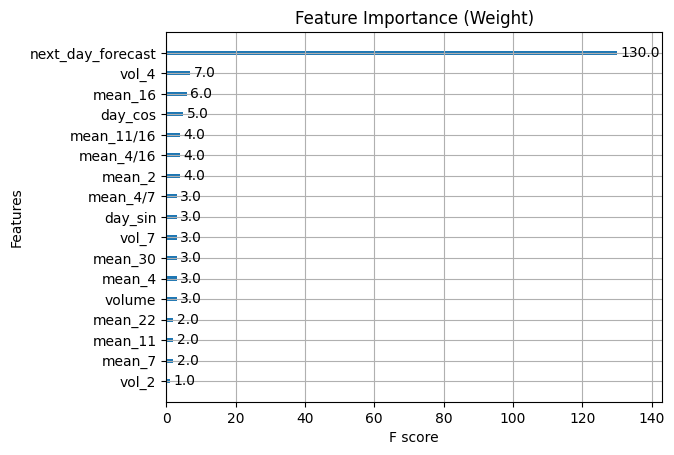

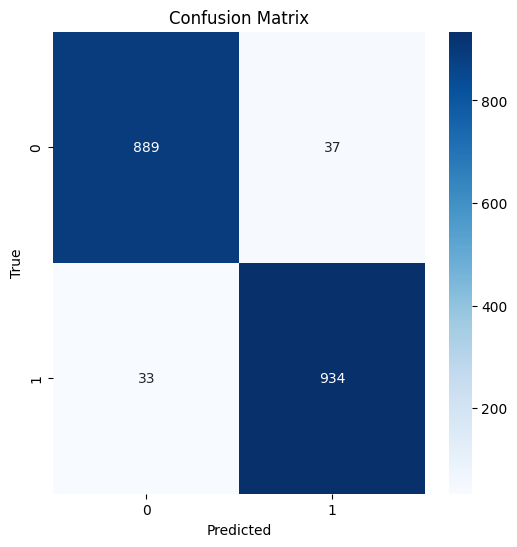

In [66]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameters
best_param = {
    'max_depth': 8,
    'learning_rate': 0.085,
    'subsample': 0.5,
    'colsample_bytree': 0.7, 
    'gamma': 6.5,
    'min_child_weight': 0,
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'device': 'cuda'
}
num_boost_round = 130

# Convert data to DMatrix format
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost model
bst = xgb.train(best_param, train_data, num_boost_round)

# Make predictions (for demonstration purposes)
y_pred = (bst.predict(test_data) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Maximum accuracy: {accuracy:.6f}")

# Plot feature importance
xgb.plot_importance(bst, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()


cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [65]:
bruh

NameError: name 'bruh' is not defined

In [ ]:
dtrain = xgb.DMatrix(X, label=y)

# Train the final model
final_model = xgb.train(
    best_param,
    dtrain,
    num_boost_round=200
)
row_to_predict = row_to_predict.to_frame().T

dpredict = xgb.DMatrix(row_to_predict)

# Get prediction probability
prediction_prob = final_model.predict(dpredict)

# Get binary prediction (0 or 1)
prediction = (prediction_prob > 0.5).astype(int)

print(f"Prediction Probability: {prediction_prob[0]:.4f}")
print(f"Binary Prediction: {prediction[0]}")

ValueError: feature_names mismatch: ['next_day_forecast', 'volume', 'mean_2', 'mean_4', 'mean_7', 'mean_11', 'mean_16', 'mean_22', 'mean_30', 'vol_2', 'vol_4', 'vol_7', 'day_sin', 'day_cos', 'mean_4/7', 'mean_4/11', 'mean_4/16', 'mean_11/16'] ['next_day_forecast', 'volume', 'mean_2', 'mean_4', 'mean_7', 'mean_11', 'mean_16', 'mean_22', 'mean_30', 'vol_2', 'vol_4', 'vol_7', 'day_sin', 'day_cos']
expected mean_4/16, mean_4/7, mean_11/16, mean_4/11 in input data